In [1]:
from hashtable import Node, hashtable as Htable

In [2]:
pixels = [(1,1),(1,2),(1,3),(1,4),(5,1),(1,6),(7,1),(8,1),(9,1),(10,1),(11,1),(1,12),(13,1),(1,14),(15,1)]
table = Htable(int(len(pixels)/5))
for x in pixels:
    table.add(x)


In [2]:

import pandas as pd
import math
import haversine as hs
import warnings
warnings.filterwarnings("ignore")
from geojson import Polygon, Feature, FeatureCollection, Point
from collections import OrderedDict
import json
import datetime
import time
from geopy.geocoders import Nominatim
import random
import requests
import urllib
from shapely.geometry import Polygon as P, shape
import hashtable



# Defines functions
def stationsearch(lat, long):
  for a in range(0,len(Stations)):
    # Using the GC Distance is more accurate but slighly slower
    if hs.haversine((lat,long),(Stations[a][9],Stations[a][8]),unit=hs.Unit.MILES) < Max_Walkto_Train_Outside_ODD:
      global station
      station = Stations[a][5]
      global line
      line = Stations[a][7]
      return True
  return False

def countyCheck(Additional_Countys_Fips):
  if len(Additional_Countys_Fips) == 0:
    return False
  for a in Additional_Countys_Fips:
    if sheet["OFIPS"][x] == a[0] or sheet["DFIPS"][x] == a[0]:
      global station
      global line
      station = a[2]
      line = a[1]
      return True
  return False
  

def toCord(lat, long):
  xpixel = math.floor(138.348 * (long + 97.5) * math.cos(math.radians(lat)))
  ypixel = math.floor(138.348 * (lat - 37.0))
  return xpixel, ypixel

def toFips(state):
  return(Fips_Code[state])

def format_Numbers(number):
  return "{:,.0f}".format(number)


def getArea(Polygon_Area):
   lng1, lat1, lng2, lat2 = Polygon_Area.bounds
   x1, y1 = toCord(lat1,lng2)
   
   x2, y2 = toCord(lat2,lng1)
   
   pixels = []
   allpixels = []
   
   for x in range(x2,x1):
    for y in range(y1,y2):
        allpixels.append((x,y))

   for x in allpixels:
    i = x[0]
    j = x[1]
    bottom_left_lat = 37.0 + 0.00722814*(j)
    bottom_left_lng = -97.5 + 0.00722814*(i)/math.cos(math.radians(bottom_left_lat))
    bottom_left = (bottom_left_lng, bottom_left_lat)

    bottom_right_lat = 37.0 + 0.00722814*(j)
    bottom_right_lng = -97.5 + 0.00722814*(i+1)/math.cos(math.radians(bottom_right_lat))
    bottom_right = (bottom_right_lng, bottom_right_lat)

    top_right_lat = 37.0 + 0.00722814*(j+1)
    top_right_lng = -97.5 + 0.00722814*(i+1)/math.cos(math.radians(top_right_lat))
    top_right = (top_right_lng, top_right_lat)

    top_left_lat = 37.0 + 0.00722814*(j+1)
    top_left_lng = -97.5 + 0.00722814*(i)/math.cos(math.radians(top_left_lat))
    top_left = (top_left_lng, top_left_lat)

    

    pixel = P([bottom_left, bottom_right, top_right, top_left])
    if Polygon_Area.intersects(pixel):
        pixels.append((i,j))
    
   return pixels

In [5]:
from geopy.geocoders import Nominatim

def get_nearest_street_address(lat, lng):
    geolocator = Nominatim(user_agent="my_app")
    location = geolocator.reverse(f"{lat}, {lng}")
    if "United States" in location.raw['address']['country']:
        return location
    else:
        return None
    
def get_lat_long(street_address):
    geolocator = Nominatim(user_agent="my_app")
    location = geolocator.geocode(street_address)
    if location is not None:
        return location.latitude, location.longitude
    else:
        return None


In [7]:
import networkx as nx
import math

def get_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the earth in km
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + \
        math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * \
        math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c  # Distance in km
    return d

def create_min_spanning_road_network(nodes):
    # Create a new graph
    G = nx.Graph()

    # Add the nodes to the graph
    for i, (lat, lng) in enumerate(nodes):
        G.add_node(i, pos=(lng, lat))  # Note the order of lng and lat

    # Add edges between all pairs of nodes
    for i, (lat1, lng1) in enumerate(nodes):
        for j, (lat2, lng2) in enumerate(nodes):
            if i != j:
                # Compute the distance between the nodes
                dist = get_distance(lat1, lng1, lat2, lng2)

                # Add an edge between the nodes with weight equal to the distance
                G.add_edge(i, j, weight=dist)

    # Compute the minimum spanning tree of the graph
    mst = nx.minimum_spanning_tree(G)

    # Create a new graph with only the edges in the minimum spanning tree
    mst_graph = nx.Graph()
    for u, v, d in mst.edges(data=True):
        mst_graph.add_edge(u, v, weight=d['weight'])

    # Set the pos attribute for all nodes
    pos = nx.get_node_attributes(mst_graph, 'pos')
    nx.set_node_attributes(mst_graph, pos, 'pos')

    return mst_graph


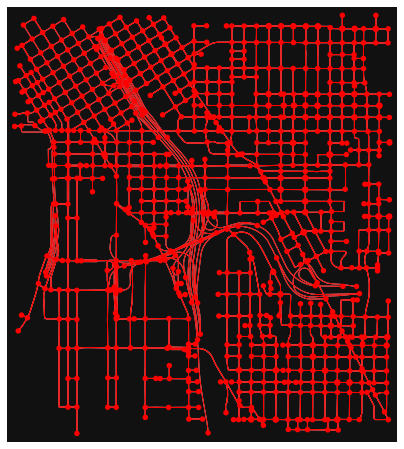

(<Figure size 576x576 with 1 Axes>, <AxesSubplot: >)

In [5]:
import osmnx as ox
import networkx as nx

# Define the bounding box of the region of interest
north, south, east, west = 47.61, 47.58, -122.30, -122.34
bbox = (north, south, east, west)

# Download the road network graph for the region of interest
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Convert the graph to an undirected graph
G_undirected = G.to_undirected()

# Compute the minimum spanning tree of the graph
mst = nx.minimum_spanning_tree(G_undirected)
mst = ox.speed.add_edge_speeds(G)

# test = nx.subgraph(29978282,30003744,30003774,53068778,53142103,53151740,53210031,246768833,246768807,2372771874)

# Plot the road network and the minimum spanning tree
fig, ax = ox.plot_graph(G, node_color='gray', node_size=5, edge_color='lightgray', show=False, close=False)
ox.plot_graph(mst, node_color='red', node_size=30, edge_color='red', edge_linewidth=1, ax=ax, show=True, close=False)


In [36]:
import random
# Extract the latitude and longitude of each node in the graph
node_gdf, edge_gdf = ox.graph_to_gdfs(G, nodes=mst.nodes())

take = []
# Print the latitude and longitude of each node in the graph
for node in mst.nodes():
    latitude = node_gdf.loc[node, 'y']
    longitude = node_gdf.loc[node, 'x']
    # print(f"Node {node}: ({latitude}, {longitude})")
    x = random.random()
    if x <0.005:
        # take.append((longitude,latitude))
        take.append(node)

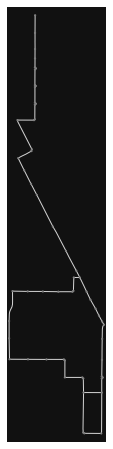

In [60]:
a = nx.subgraph(G_undirected,take)
b = nx.minimum_spanning_tree(a)
c = ox.shortest_path(G_undirected,take,take)
d = nx.subgraph(G_undirected,e)
fig, ax = ox.plot_graph(d, node_color='gray', node_size=5, edge_color='lightgray', show=False, close=False, save=True)


In [67]:
e = []
for x in take:
    for y in take:
        e.extend(ox.shortest_path(G_undirected, x,y))
# c = ox.shortest_path(G_undirected, take[0],take[20])
print(e)
d = nx.subgraph(G_undirected,e)
gdf = ox.graph_to_gdfs(d)


# fig, ax = ox.plot_graph(d, node_color='gray', node_size=5, edge_color='lightgray', show=False, close=False)

[53130385, 53130385, 53130383, 9190642591, 9190642592, 9190642593, 53130378, 53130377, 1807547989, 53130376, 1807547986, 53136409, 151942802, 53090756, 53086620, 30888236, 30888195, 1851247309, 53029515, 30888075, 53239403, 246768814, 9188385524, 9188385523, 53155366, 9188413630, 9188413632, 9188430102, 53114066, 9188430100, 9188434747, 9188434746, 9188434745, 9188436169, 9188436157, 9188436158, 281497076, 53089016, 53129320, 53168084, 53130385, 9190705894, 9190705893, 53199573, 9190642612, 9190642613, 53134853, 9190634822, 9190634821, 53128225, 53244433, 53215758, 53168084, 53129320, 53089016, 281497076, 9188436158, 9188436157, 9188436169, 9188434745, 9188434746, 9188434747, 9188430100, 53114066, 9188430102, 9188413632, 9188413630, 53155366, 9188385523, 9188385524, 246768814, 53239403, 30888075, 53029515, 1851247309, 30888195, 30888236, 53086620, 53090756, 151942802, 53136409, 1807547986, 53130376, 1807547989, 53130377, 53130378, 9190642593, 9190642592, 9190642591, 53130383, 53130385,

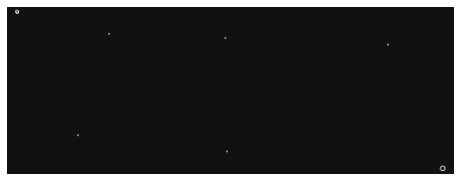

In [4]:
import osmnx as ox
import networkx as nx
import pandas as pd
from collections import OrderedDict
from shapely.geometry import mapping
import json

# Handles bringing in the centers of mass
file = "data\Detroid2_pixelCOMs.geojson"

points = []
centerpoints = pd.read_json(file)
for x in centerpoints['features']:
    points.append((x['geometry']['coordinates'][0],x['geometry']['coordinates'][1]))

# Define the bounding box of the region of interest
# north, south, east, west = 47.61, 47.58, -122.30, -122.34
north, south, east, west = 0, 90, -180,0
for x in points:
    if x[1] > north:
        north = x[1]
    elif x[1]< south:
        south = x[1]
    if x[0] > east:
        east = x[0]
    elif x[0] < west:
        west = x[0]

bbox = (north, south, east, west)

# Download the road network graph for the region of interest
G = ox.graph_from_bbox(north+0.1, south-0.1, east-.1, west+0.1, network_type='drive')

# Convert the graph to an undirected graph
G_undirected = G.to_undirected()


# Gets nearest node to center of mass
points2 = []
for x in points:
    points2.append(ox.nearest_nodes(G_undirected,x[0],x[1]))
points2 = list(OrderedDict.fromkeys(points2))

# Gets routes between centers of mass and creates subgraph
routepoints = []
for x in points2:
    for y in points2:
        routepoints.extend(ox.shortest_path(G_undirected,x,y)) 
routepoints = list(OrderedDict.fromkeys(routepoints))

sub = nx.subgraph(G_undirected,points2)

# convert the graph to a GeoJSON feature collection
features = []
for u, v, data in sub.edges(data=True):
    # check if the edge has a 'geometry' attribute
    if 'geometry' in data:
        # add geometry for the road segment
        line = mapping(data['geometry'])
        # add properties for the road segment
        
        # create the feature for the road segment
        feature = {
            "type": "Feature",
            "geometry": line
        }
        # add the feature to the feature collection
        features.append(feature)

# create the GeoJSON file
geojson = {
    "type": "FeatureCollection",
    "features": features
}
with open("road_network.geojson", "w") as outfile:
    json.dump(geojson, outfile)

fig, ax = ox.plot_graph(sub, node_color='gray', node_size=5, edge_color='lightgray', show=False, close=False, save=True)

In [13]:
points2.append(ox.nearest_nodes(G_undirected,50.777942, -129.821740))
points2 = list(OrderedDict.fromkeys(points2))
print(points2)

[62917084, 62971398, 62592813, 4512645240, 62759952, 62815444, 62838010, 2416619254, 660518575, 62856354, 63029691, 62991318, 6424308438, 63020281, 282145469, 2486626264, 62871821, 62739064, 62871736, 62716725, 62593608, 62668868, 62634660]


In [10]:
print(len(routepoints))

2683


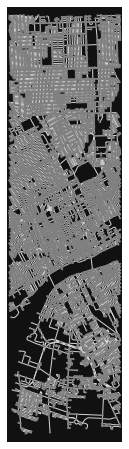

In [16]:
fig, ax = ox.plot_graph(G_undirected, node_color='gray', node_size=5, edge_color='lightgray', show=False, close=False, save=True)

In [17]:
# convert the graph to a GeoJSON feature collection
features = []
for u, v, data in G_undirected.edges(data=True):
    # check if the edge has a 'geometry' attribute
    if 'geometry' in data:
        # add geometry for the road segment
        line = mapping(data['geometry'])
        # add properties for the road segment
        
        # create the feature for the road segment
        feature = {
            "type": "Feature",
            "geometry": line
        }
        # add the feature to the feature collection
        features.append(feature)

# create the GeoJSON file
geojson = {
    "type": "FeatureCollection",
    "features": features
}
with open("road_network.geojson", "w") as outfile:
    json.dump(geojson, outfile)

In [13]:
from collections import OrderedDict


In [4]:
import osmnx as ox
import networkx as nx
import json
from shapely.geometry import mapping

# specify the location and type of network you want to retrieve
place = "New York City, New York, USA"
network_type = "drive"

# retrieve the road network as a graph
G = ox.graph_from_place(place, network_type=network_type)

# convert the graph to a GeoJSON feature collection
features = []
for u, v, data in G.edges(data=True):
    # check if the edge has a 'geometry' attribute
    if 'geometry' in data:
        # add geometry for the road segment
        line = mapping(data['geometry'])
        # add properties for the road segment
        
        # create the feature for the road segment
        feature = {
            "type": "Feature",
            "geometry": line
        }
        # add the feature to the feature collection
        features.append(feature)

# create the GeoJSON file
geojson = {
    "type": "FeatureCollection",
    "features": features
}
with open("road_network.geojson", "w") as outfile:
    json.dump(geojson, outfile)


In [ ]:
from math import sqrt

def distance(p1, p2):
    return sqrt((p1.lon - p2.lon) ** 2 + (p1.lat - p2.lat) ** 2)

import osmium
import requests
import json

class NodeHandler(osmium.SimpleHandler):
    def __init__(self):
        super(NodeHandler, self).__init__()
        self.nodes = []

    def node(self, n):
        self.nodes.append(n)

def get_nearest_osrm_node(lat, lon):
    url = f'http://router.project-osrm.org/nearest/v1/driving/{lon},{lat}'
    response = requests.get(url)
    result = json.loads(response.content.decode('utf-8'))
    node_id = result['waypoints'][0]['nodes'][0]
    return node_id

def get_minimum_road_network(points):
    # Get the nearest OSRM nodes for each point
    nodes = [get_nearest_osrm_node(lat, lon) for lat, lon in points]

    # Load the OSRM graph for the given nodes
    node_handler = NodeHandler()
    osmium.io.Reader(file_name='{}.osrm'.format(nodes[0]), read_nodes=True).apply(node_handler)

    # Construct the subset of the OSRM graph
    osrm_nodes = node_handler.nodes
    osrm_edges = []
    for node in osrm_nodes:
        for edge in node.edges():
            if edge.target().ref() in osrm_nodes:
                osrm_edges.append((edge.source().ref(), edge.target().ref()))

    # Compute the minimum road network using the modified Kruskal's algorithm
    g = Graph(len(osrm_nodes))
    for u, v in osrm_edges:
        weight = distance(osrm_nodes[u].location, osrm_nodes[v].location)
        g.add_edge(u, v, weight)

    subset = [True if i in nodes else False for i in range(len(osrm_nodes))]
    minimum_road_network = g.kruskal(subset)

    # Convert the edges to a list of points
    result = []
    for u, v, _ in minimum_road_network:
        u_loc = osrm_nodes[u].location
        v_loc = osrm_nodes[v].location
        result.append((u_loc.lat, u_loc.lon))
        result.append((v_loc.lat, v_loc.lon))

    return result

